In [1]:
import pandas as pd
import numpy as np
import statistics
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

from collections import Counter
from sklearn import preprocessing
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score,recall_score, r2_score, f1_score, precision_score
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

%matplotlib inline
plt.rcParams["figure.figsize"] = (16, 9) # (w, h)


### Загрузка датасета

In [2]:
DATA_PATH = "data_breast.csv"

In [3]:
data_breast = pd.read_csv(DATA_PATH)
data_breast.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


**Attribute Information:**

1) ID number 
2) Diagnosis (M = malignant, B = benign) 
3-32) 

Ten real-valued features are computed for each cell nucleus: 

a) radius (mean of distances from center to points on the perimeter) <br>
b) texture (standard deviation of gray-scale values) <br>
c) perimeter <br>
d) area <br>
e) smoothness (local variation in radius lengths) <br>
f) compactness (perimeter^2 / area - 1.0) <br>
g) concavity (severity of concave portions of the contour) <br>
h) concave points (number of concave portions of the contour) <br>
i) symmetry <br>
j) fractal dimension ("coastline approximation" - 1)

In [4]:
data_breast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
id                         569 non-null int64
diagnosis                  569 non-null object
radius_mean                569 non-null float64
texture_mean               569 non-null float64
perimeter_mean             569 non-null float64
area_mean                  569 non-null float64
smoothness_mean            569 non-null float64
compactness_mean           569 non-null float64
concavity_mean             569 non-null float64
concave points_mean        569 non-null float64
symmetry_mean              569 non-null float64
fractal_dimension_mean     569 non-null float64
radius_se                  569 non-null float64
texture_se                 569 non-null float64
perimeter_se               569 non-null float64
area_se                    569 non-null float64
smoothness_se              569 non-null float64
compactness_se             569 non-null float64
concavity_se               569 non

Как видно, датасет содержит 569 записей, нулевых значений нет. Признак "Unnamed: 32" нужно удалить - все значения в нем нулевые. Также можно удалить признак "id", т.к. он просто содержит индетификатор записи и не влияет на результирующую переменную. Не считая их, датасет содержит 31 признак, 30 из них имеют тип float и один - это таргет-параметр diagnosis со значениями M и B. 

In [5]:
# Удаляем ненужный признак Unnamed: 32
data_breast.drop(['Unnamed: 32', 'id'], axis=1, inplace=True)
data_breast.shape

(569, 31)

Для удобства дальнейшего использования переименуем некоторые колонки:

In [6]:
data_breast.rename(columns={'concave points_mean':'concave_points_mean',
                          'concave points_se':'concave_points_se',
                          'concave points_worst':'concave_points_worst'}, 
                 inplace=True)

Таргет-параметром является diagnosis со значениями M и B. Посмотрим, какого их распределение.

In [7]:
data_breast['diagnosis'].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

Diagnosis является категориальным параметром, причем принимает только 2 значения B – benign (содержимое биоптата доброкачественное) и M – malicious (содержимое биоптата злокачественное). Следовательно, эту задачу можно рассматривать как бинарную классификацию.  

In [8]:
data_breast['diagnosis'] = data_breast['diagnosis'].map({'M' : 1, 'B' : 0})

### Основные статистики

In [9]:
data_breast.describe()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


Развернутая информация

In [10]:
def get_mode(column):
    """Выводит значение моды для переменной column"""
    # подсчет количества встречаемости значений
    column_counts = Counter(column)

    # Алгоритм поиска максимума
    maxp = 0
    mode = []  # список, т.к. может быть несколько мод
    column_counts = column_counts.most_common()
    for elem in column_counts:
        if elem[1] >= maxp:
            maxp = elem[1]
            mode.append(elem[0])

    # проверка на наличие моды
    if maxp == 1:
        print('Моды в данном множестве нет, все значения встречаются один раз')
    elif len(mode) >= 2:
        len_mode = len(mode)
        mode = ', '.join(str(e) for e in mode) # перевод списка в строковый вид
        print('Значение моды (данные содержат', len_mode, 'мод(ы)):', mode, 'Количество встречаемости:', maxp)
    else:
        mode = ' '.join(str(e) for e in mode) # перевод списка в строковый вид
        print('Значение моды:', mode, 'Количество встречаемости:', maxp)

In [11]:
def get_statistics(column):
    print('Медиана: ', statistics.median(column))
    print('Среднее: ', statistics.mean(column))
    print('Стандартное отклонение: ', statistics.pstdev(column))
    print('Минимум: ', min(column))
    print('Максимум: ', max(column))
    print('Размах: ', max(column) - min(column))
    get_mode(column)
    print('\n')

In [12]:
column_names = data_breast.columns.values.tolist()[1:]
for column in column_names:
    print('Основные статистики для признака \033[1m', column, '\033[0m')
    get_statistics(data_breast[column])

Основные статистики для признака  radius_mean 
Медиана:  13.37
Среднее:  14.127291739894552
Стандартное отклонение:  3.520950760711062
Минимум:  6.981
Максимум:  28.11
Размах:  21.128999999999998
Значение моды: 12.34 Количество встречаемости: 4


Основные статистики для признака  texture_mean 
Медиана:  18.84
Среднее:  19.289648506151142
Стандартное отклонение:  4.297254637090422
Минимум:  9.71
Максимум:  39.28
Размах:  29.57
Значение моды (данные содержат 9 мод(ы)): 15.7, 16.84, 19.83, 20.52, 18.22, 14.93, 17.46, 18.9, 16.85 Количество встречаемости: 3


Основные статистики для признака  perimeter_mean 
Медиана:  86.24
Среднее:  91.96903339191564
Стандартное отклонение:  24.27761929305318
Минимум:  43.79
Максимум:  188.5
Размах:  144.71
Значение моды (данные содержат 3 мод(ы)): 82.61, 87.76, 134.7 Количество встречаемости: 3


Основные статистики для признака  area_mean 
Медиана:  551.1
Среднее:  654.8891036906854
Стандартное отклонение:  351.60475406323
Минимум:  143.5
Максимум:  250

### Cтратегия для работы с пропущенными значениями

Данный датасет не содержит нулевых значений, как уже было указано выше.

### Корреляционная матрица

In [13]:
data_breast.corr()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
diagnosis,1.000000,0.730029,0.415185,0.742636,0.708984,0.358560,0.596534,0.696360,0.776614,0.330499,...,0.776454,0.456903,0.782914,0.733825,0.421465,0.590998,0.659610,0.793566,0.416294,0.323872
radius_mean,0.730029,1.000000,0.323782,0.997855,0.987357,0.170581,0.506124,0.676764,0.822529,0.147741,...,0.969539,0.297008,0.965137,0.941082,0.119616,0.413463,0.526911,0.744214,0.163953,0.007066
texture_mean,0.415185,0.323782,1.000000,0.329533,0.321086,-0.023389,0.236702,0.302418,0.293464,0.071401,...,0.352573,0.912045,0.358040,0.343546,0.077503,0.277830,0.301025,0.295316,0.105008,0.119205
perimeter_mean,0.742636,0.997855,0.329533,1.000000,0.986507,0.207278,0.556936,0.716136,0.850977,0.183027,...,0.969476,0.303038,0.970387,0.941550,0.150549,0.455774,0.563879,0.771241,0.189115,0.051019
area_mean,0.708984,0.987357,0.321086,0.986507,1.000000,0.177028,0.498502,0.685983,0.823269,0.151293,...,0.962746,0.287489,0.959120,0.959213,0.123523,0.390410,0.512606,0.722017,0.143570,0.003738
smoothness_mean,0.358560,0.170581,-0.023389,0.207278,0.177028,1.000000,0.659123,0.521984,0.553695,0.557775,...,0.213120,0.036072,0.238853,0.206718,0.805324,0.472468,0.434926,0.503053,0.394309,0.499316
compactness_mean,0.596534,0.506124,0.236702,0.556936,0.498502,0.659123,1.000000,0.883121,0.831135,0.602641,...,0.535315,0.248133,0.590210,0.509604,0.565541,0.865809,0.816275,0.815573,0.510223,0.687382
concavity_mean,0.696360,0.676764,0.302418,0.716136,0.685983,0.521984,0.883121,1.000000,0.921391,0.500667,...,0.688236,0.299879,0.729565,0.675987,0.448822,0.754968,0.884103,0.861323,0.409464,0.514930
concave_points_mean,0.776614,0.822529,0.293464,0.850977,0.823269,0.553695,0.831135,0.921391,1.000000,0.462497,...,0.830318,0.292752,0.855923,0.809630,0.452753,0.667454,0.752399,0.910155,0.375744,0.368661
symmetry_mean,0.330499,0.147741,0.071401,0.183027,0.151293,0.557775,0.602641,0.500667,0.462497,1.000000,...,0.185728,0.090651,0.219169,0.177193,0.426675,0.473200,0.433721,0.430297,0.699826,0.438413


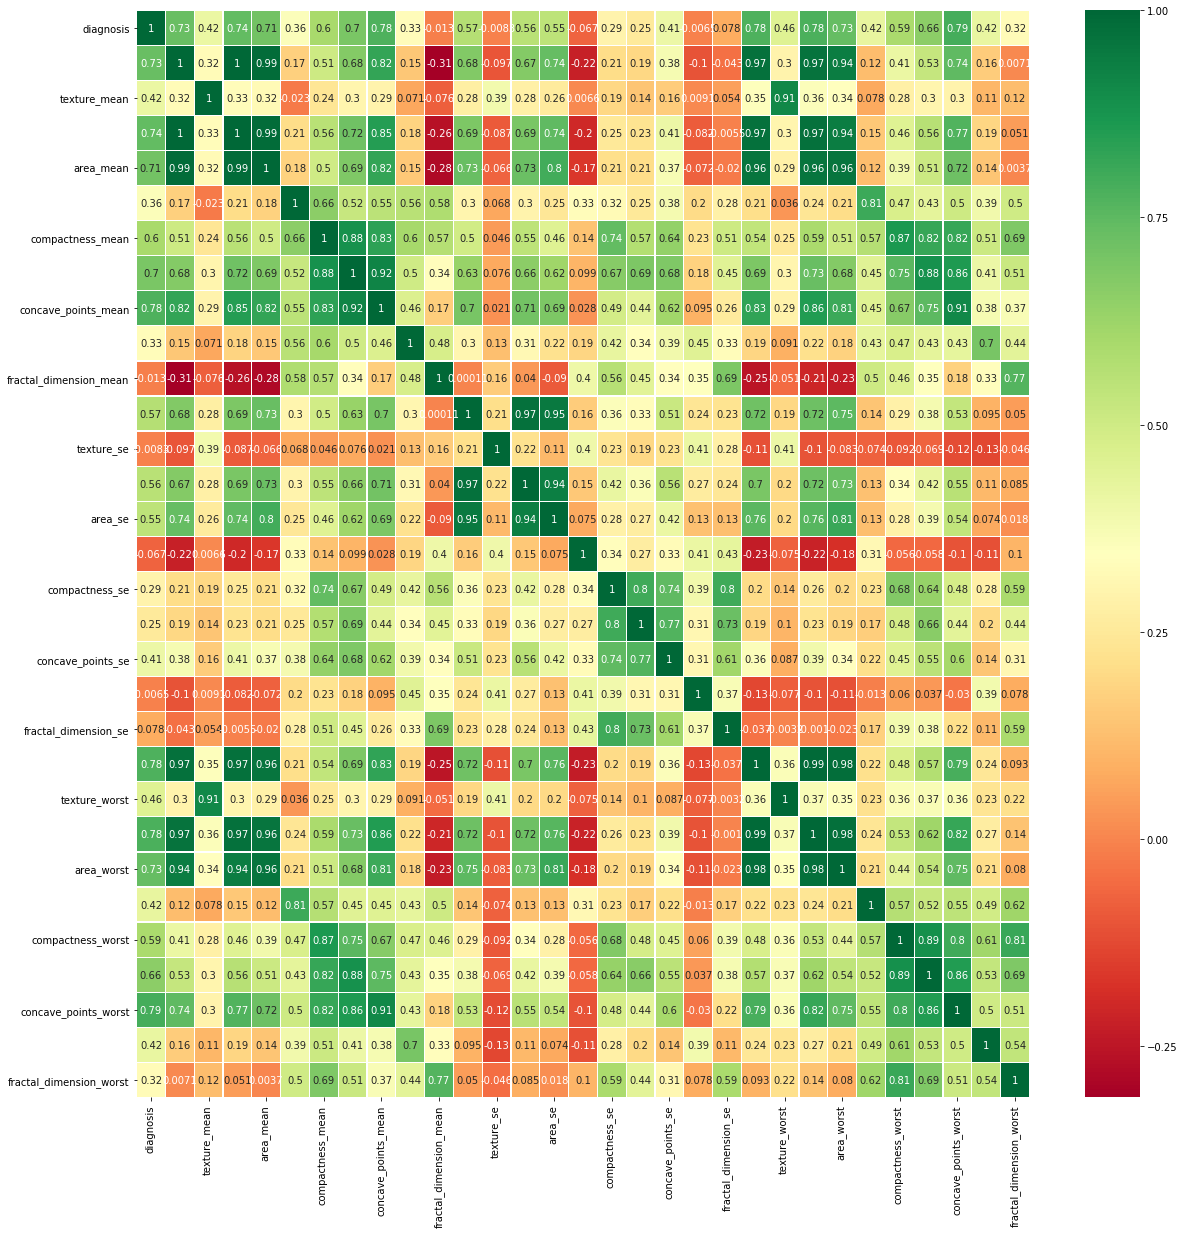

In [14]:
sns.heatmap(data_breast.corr(), annot=True, cmap='RdYlGn', linewidths=0.2) 
fig = plt.gcf()
fig.set_size_inches(20,20)
plt.show()

Как видно, датасет содержит много параметров, которые имеют высокую взаимную корреляцию.

### Визуализация взаимосвязей между переменными

Для корректной визуализации и дальнейшей работы нормализуем данные.

In [15]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
data_features = data_breast.columns[~data_breast.columns.isin(['diagnosis'])]
                                   
x_scaled = min_max_scaler.fit_transform(data_breast[data_features].values)
data_breast_features_norm = pd.DataFrame(x_scaled, columns=data_breast[data_features].columns.values.tolist(),
                                        index = data_breast.index)

data_breast[data_features] = data_breast_features_norm

In [16]:
data_breast.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,1,0.521037,0.022658,0.545989,0.363733,0.593753,0.792037,0.703140,0.731113,0.686364,...,0.620776,0.141525,0.668310,0.450698,0.601136,0.619292,0.568610,0.912027,0.598462,0.418864
1,1,0.643144,0.272574,0.615783,0.501591,0.289880,0.181768,0.203608,0.348757,0.379798,...,0.606901,0.303571,0.539818,0.435214,0.347553,0.154563,0.192971,0.639175,0.233590,0.222878
2,1,0.601496,0.390260,0.595743,0.449417,0.514309,0.431017,0.462512,0.635686,0.509596,...,0.556386,0.360075,0.508442,0.374508,0.483590,0.385375,0.359744,0.835052,0.403706,0.213433
3,1,0.210090,0.360839,0.233501,0.102906,0.811321,0.811361,0.565604,0.522863,0.776263,...,0.248310,0.385928,0.241347,0.094008,0.915472,0.814012,0.548642,0.884880,1.000000,0.773711
4,1,0.629893,0.156578,0.630986,0.489290,0.430351,0.347893,0.463918,0.518390,0.378283,...,0.519744,0.123934,0.506948,0.341575,0.437364,0.172415,0.319489,0.558419,0.157500,0.142595


Посмотрим графики распределения величин. В основном они соответсвуют нормальному распределению.

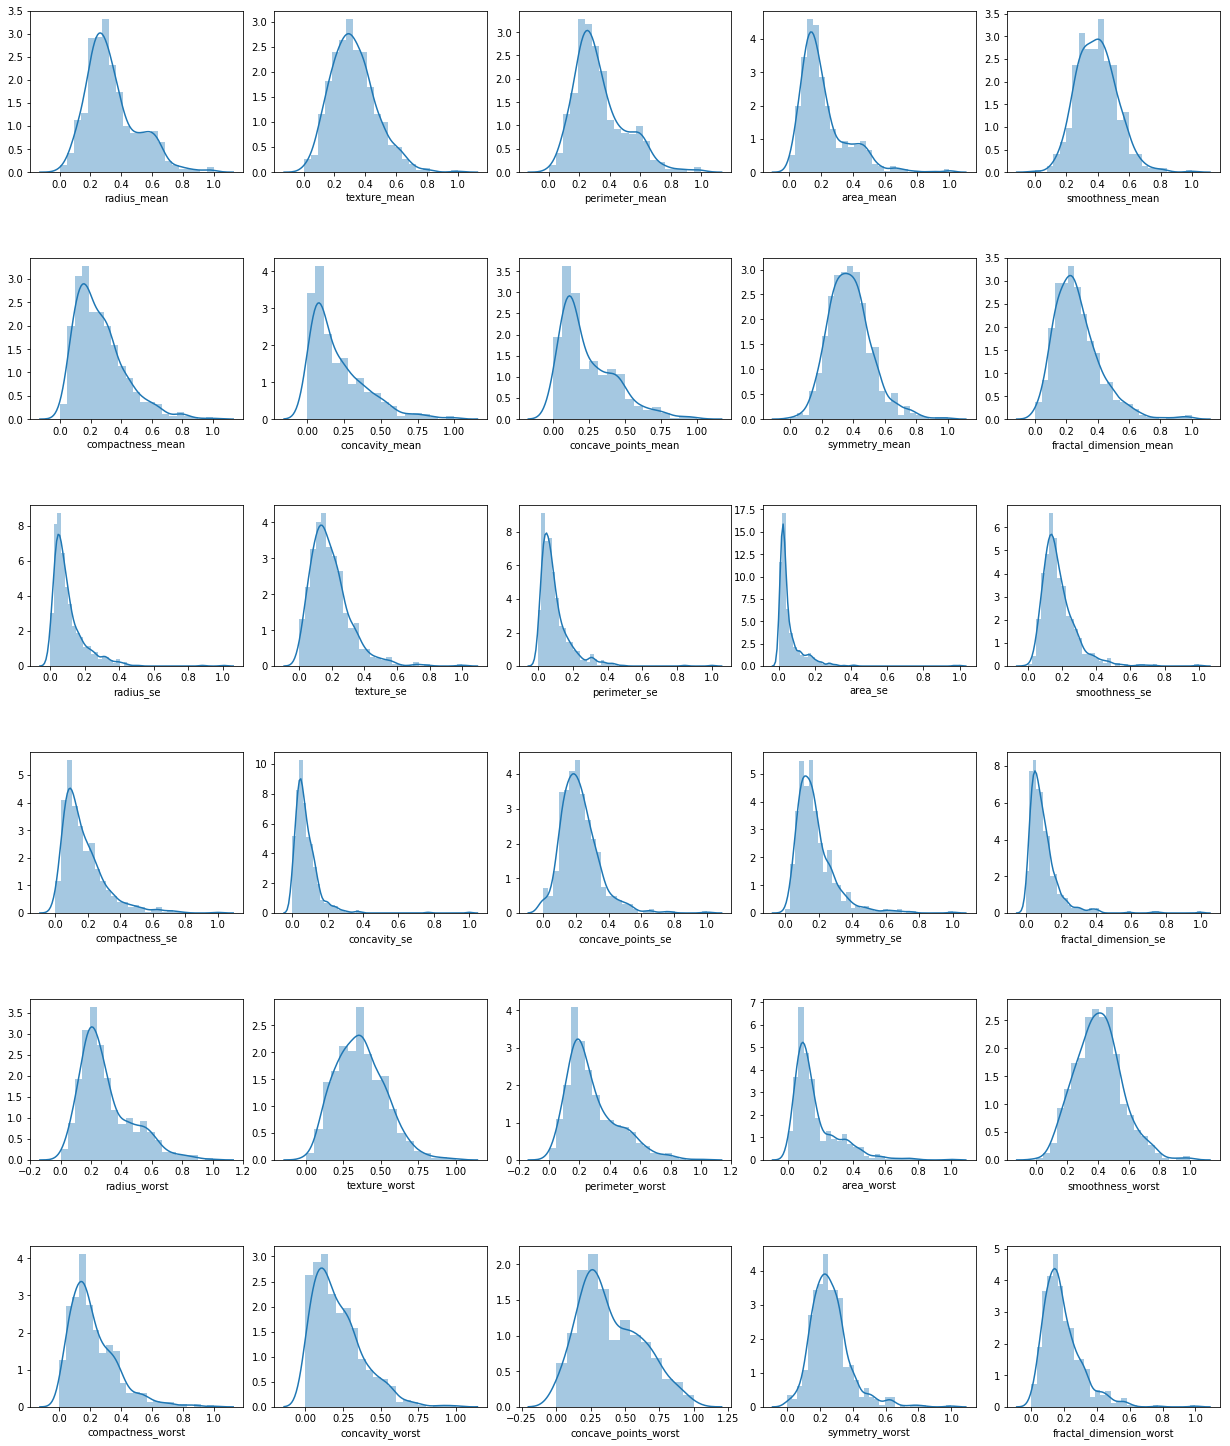

In [17]:
fig, axs = plt.subplots(ncols=5, nrows=6, figsize=(17, 20))
index = 0
axs = axs.flatten()
for k,v in data_breast_features_norm.items():
    sns.distplot(v, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)
plt.show()

Посмотрим распределения и выбросы в данных с помощью boxplot для 3-х групп параметров (mean, se, worst) относительно значения таргет-параметра diagnosis.

In [18]:
features_mean = ['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean']

features_se = ['diagnosis', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se',
       'fractal_dimension_se']

features_worst = ['diagnosis', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave_points_worst',
       'symmetry_worst', 'fractal_dimension_worst']

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

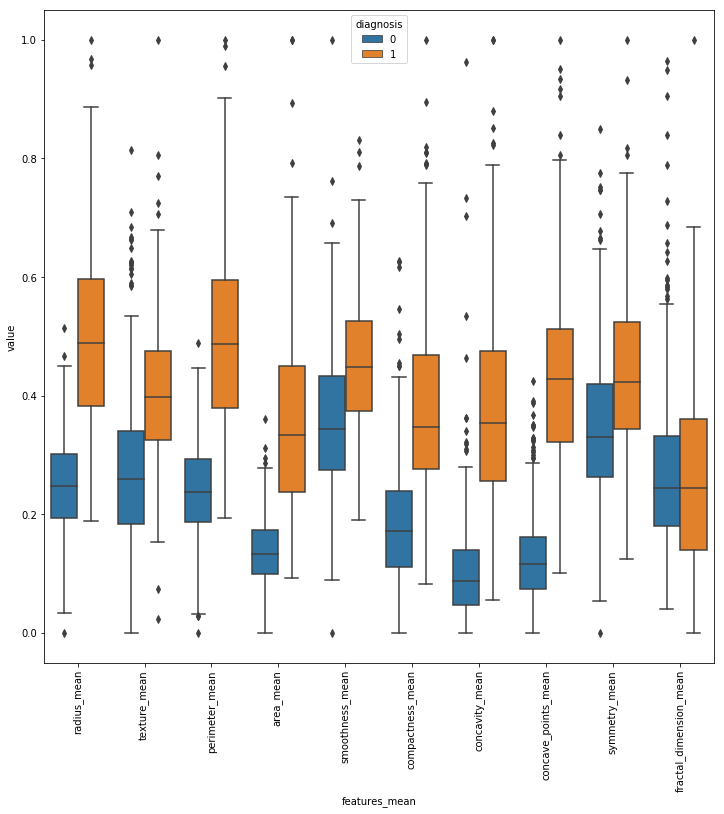

In [19]:
# для группы значений mean
plt.figure(figsize=(12,12))
sns.boxplot(x='features_mean', y="value", hue="diagnosis", data=data_breast[features_mean].melt(id_vars='diagnosis', 
                                                                                           var_name='features_mean', 
                                                                                           value_name='value'))
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

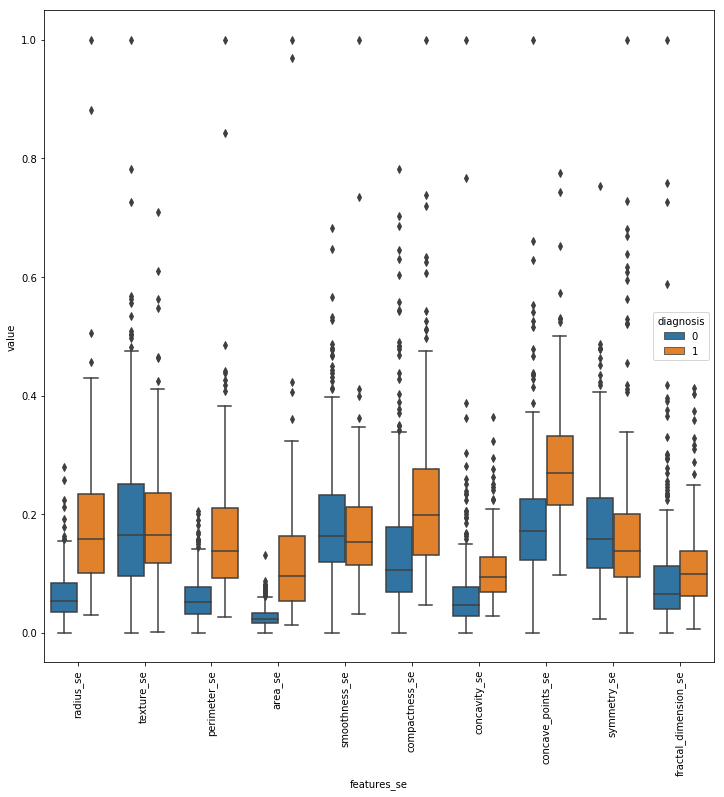

In [20]:
# для группы значений se
plt.figure(figsize=(12,12))
sns.boxplot(x='features_se', y="value", hue="diagnosis", data=data_breast[features_se].melt(id_vars='diagnosis', 
                                                                                           var_name='features_se', 
                                                                                           value_name='value'))
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

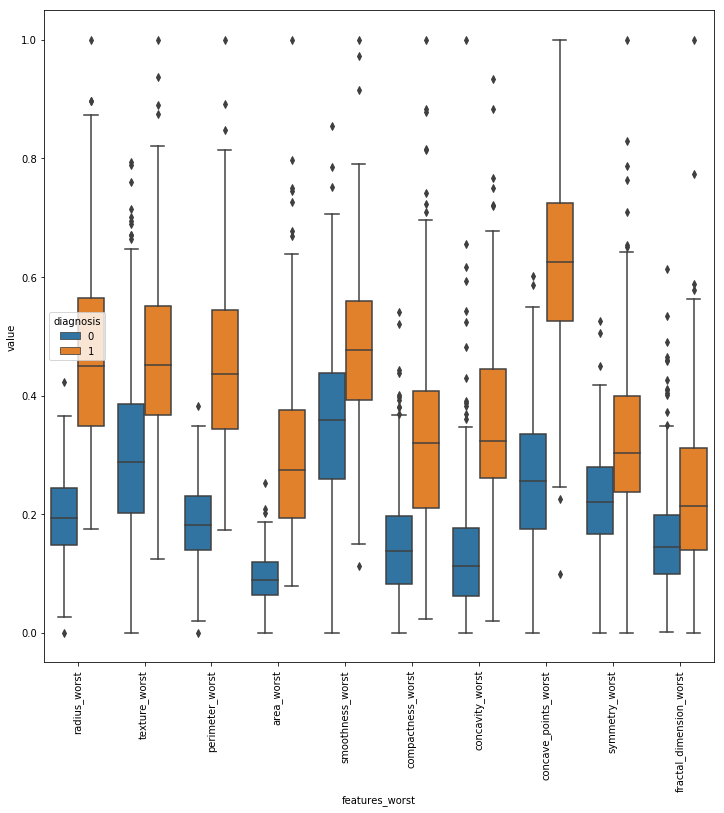

In [21]:
# для группы значений worst
plt.figure(figsize=(12,12))
sns.boxplot(x='features_worst', y="value", hue="diagnosis", data=data_breast[features_worst].melt(id_vars='diagnosis', 
                                                                                           var_name='features_worst', 
                                                                                           value_name='value'))
plt.xticks(rotation=90)

Исходя из этих графиков, можно сделать вывод, что, во-первых, данные содержат много выбросов. Во-вторых, при значении diagnosis 1 (злокачественное содержимое) значения параметров имеют больший максимум, медиану и межквартильный размах (особенно это видно для групп mean и worst).

Как уже было видно, некоторые параметры сильно коррелированы. Например:

1) параметры concavity_mean и concave_points_mean

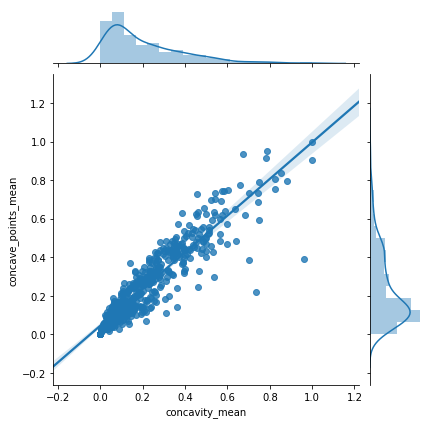

In [22]:
sns.jointplot(x='concavity_mean', y='concave_points_mean', 
              data=data_breast, kind='reg')

In [23]:
# Корреляция Пирсона
pearsonr(data_breast['concavity_mean'], data_breast['concave_points_mean'])

(0.9213910263788595, 6.78879135117187e-235)

2) параметры concavity_worst и compactness_worst

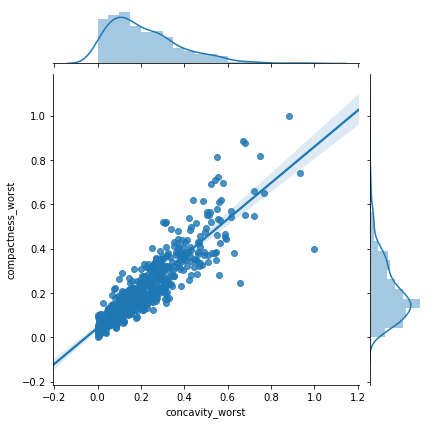

In [24]:
sns.jointplot(x='concavity_worst', y='compactness_worst', 
              data=data_breast, kind='reg')

In [25]:
# Корреляция Пирсона
pearsonr(data_breast['concavity_worst'], data_breast['compactness_worst'])

(0.8922608987764691, 5.9735433836017485e-198)

3) параметры fractal_dimension_se и compactness_se

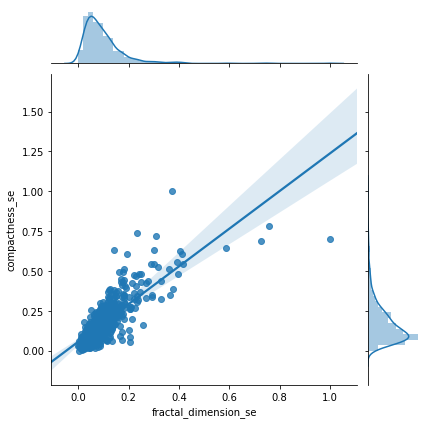

In [26]:
sns.jointplot(x='fractal_dimension_se', y='compactness_se', 
              data=data_breast, kind='reg')

In [27]:
# Корреляция Пирсона
pearsonr(data_breast['fractal_dimension_se'], data_breast['compactness_se'])

(0.803268817661767, 1.0613883898655669e-129)

### Проверка взаимосвязи между переменными с помощью статистических методов

In [28]:
columns = 'diagnosis ~ radius_mean + texture_mean + perimeter_mean + area_mean + ' +\
'smoothness_mean + compactness_mean + concavity_mean + concave_points_mean + symmetry_mean + ' +\
'fractal_dimension_mean + radius_se + texture_se + perimeter_se + area_se + smoothness_se + ' +\
'compactness_se + concavity_se + concave_points_se + symmetry_se + fractal_dimension_se + ' +\
'radius_worst + texture_worst + perimeter_worst + area_worst + smoothness_worst + compactness_worst + ' +\
'concavity_worst + concave_points_worst + symmetry_worst + fractal_dimension_worst'

In [29]:
stat = smf.ols(columns, data=data_breast).fit()
stat.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.7323,0.104,-7.009,0.000,-0.937,-0.527
radius_mean,-4.6013,3.666,-1.255,0.210,-11.803,2.600
texture_mean,0.1344,0.235,0.572,0.567,-0.327,0.596
perimeter_mean,3.4354,3.632,0.946,0.345,-3.699,10.570
area_mean,0.7493,1.238,0.605,0.545,-1.683,3.182
smoothness_mean,0.0094,0.223,0.042,0.967,-0.430,0.448
compactness_mean,-1.3765,0.435,-3.166,0.002,-2.231,-0.522
concavity_mean,0.5967,0.446,1.337,0.182,-0.280,1.474
concave_points_mean,0.4309,0.398,1.082,0.280,-0.351,1.213
symmetry_mean,0.0203,0.147,0.138,0.890,-0.269,0.309


Не все параметры статистически значимы, что можно увидеть с помощью t-теста и p-value. Для некоторых параметров p > 0.05, значит, мы не можем отклонить нулевую гипотезу, гласящую о том, что между параметрами нет зависимости. Например, у параметра smoothness_mean значение p-value = 0.967. Следовательно, между параметром diagnosis и smoothness_mean нет линейной зависимости. <br>

In [30]:
rss = np.sum(stat.resid ** 2)
rmse = np.sqrt(rss / len(stat.resid))
print("RMSE:", rmse)
print("R^2:", stat.rsquared)

RMSE: 0.22968457595258573
R^2: 0.7743246526421793


1. Значение среднеквадратичной ошибки RMSE равно 0.229<br>
2. Значение R-квадрата равно 0.774, что означает, что 77% вариативности объяснен моделью.


### Выбор и расчет стратегии Feature Selection

Т.к. модель содержит много взаимокоррелирующих параметров, сначала избавимся от параметров с высоким значением взаимной корреляции. Далее для оставшихся признаков воспользуемся методом прямого отбора для отброса менее значимых параметров. Все это позволит сократить размерность модели.

In [31]:
# создаем матрицу корреляций и верхний треугольник матрицы
corr_matrix = data_breast.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Ищем индексы колонок с корреляцией большей чем 0.85
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]
print(to_drop)

['perimeter_mean', 'area_mean', 'concavity_mean', 'concave_points_mean', 'perimeter_se', 'area_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'compactness_worst', 'concavity_worst', 'concave_points_worst']


In [32]:
# параметры, для которых будем использовать метод прямого отбора
_cols = data_breast.columns.drop('diagnosis')
_cols = _cols.drop(to_drop)
_cols

Index(['radius_mean', 'texture_mean', 'smoothness_mean', 'compactness_mean',
       'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se',
       'smoothness_se', 'compactness_se', 'concavity_se', 'concave_points_se',
       'symmetry_se', 'fractal_dimension_se', 'smoothness_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

Для проверки стратегий Feature Selection разобьем наш датасет на тест и трейн.

In [33]:
X_train, X_test, y_train, y_test = train_test_split(data_breast[data_breast.columns.drop('diagnosis')],\
                                   data_breast['diagnosis'], test_size=0.3, random_state=42)

In [34]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(398, 30) (398,)
(171, 30) (171,)


Значения среднеквадратичной ошибки и R-квадрата для исходной модели на тест и трейн выборках:

In [35]:
rand_forest = RandomForestClassifier(n_estimators=100, random_state=15)
rand_forest = rand_forest.fit(X_train, y_train)
y_pred = rand_forest.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmse

0.1873171623163388

In [36]:
r2_score(y_test, y_pred)

0.8492063492063492

Воспользуемся методом прямого отбора отдельно для выборки со всеми параметрами и выборки с выбранными параметрами.

In [37]:
# все параметры
rand_forest = RandomForestClassifier(n_estimators=100, random_state=15)

sfs_all = sfs(rand_forest, 
           k_features=7, 
           forward=True, 
           floating=False, 
           scoring='roc_auc',
           cv=10)

sfs_all = sfs_all.fit(X_train, y_train)

In [38]:
# отобранные параметры в ходе прямого отбора
sfs_all_features = list(sfs_all.k_feature_names_)
sfs_all_features

['radius_se',
 'texture_se',
 'fractal_dimension_se',
 'texture_worst',
 'perimeter_worst',
 'smoothness_worst',
 'concave_points_worst']

Рассчитаем значения среднеквадратичной ошибки и R-квадрата для модели со всеми параметрами в ходе прямого отбора sfs_all_features

In [39]:
rand_forest = RandomForestClassifier(n_estimators=100, random_state=15)
rand_forest = rand_forest.fit(X_train[sfs_all_features], y_train)
y_pred = rand_forest.predict(X_test[sfs_all_features])

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmse

0.22941573387056177

In [40]:
r2_score(y_test, y_pred)

0.7738095238095237

In [41]:
# выбранные параметры
rand_forest = RandomForestClassifier(n_estimators=100, random_state=15)

sfs_select = sfs(rand_forest, 
           k_features=7, 
           forward=True, 
           floating=False, 
           scoring='roc_auc',
           cv=10)

sfs_select = sfs_select.fit(X_train[_cols], y_train)

In [42]:
# отобранные параметры в ходе прямого отбора
sfs_select_features = list(sfs_select.k_feature_names_)
sfs_select_features

['radius_mean',
 'texture_mean',
 'radius_se',
 'smoothness_se',
 'concavity_se',
 'symmetry_se',
 'smoothness_worst']

Рассчитаем значения среднеквадратичной ошибки и R-квадрата для модели с выбранными параметрами в ходе прямого отбора sfs_select_features

In [43]:
rand_forest = RandomForestClassifier(n_estimators=100, random_state=15)
rand_forest = rand_forest.fit(X_train[sfs_select_features], y_train)
y_pred = rand_forest.predict(X_test[sfs_select_features])

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmse

0.1529438225803745

In [44]:
r2_score(y_test, y_pred)

0.8994708994708994

Как видно, для выборки с выбранными параметрами значение ошибки уменьшилось, а R-квадрата увеличилось.

### Предсказание параметра Diagnosis

In [45]:
X_train = X_train[sfs_select_features]
X_test = X_test[sfs_select_features]

1. Алгоритм случайный лес - **Random Forest**.

In [46]:
rand_forest = RandomForestClassifier(max_depth=6, min_samples_leaf=2, n_estimators=100, random_state=0)
rand_forest = rand_forest.fit(X_train, y_train)

In [47]:
y_pred_rf = rand_forest.predict(X_test)

In [48]:
pd.crosstab(y_pred_rf, y_test, colnames=['Actual Result'], rownames=['Predicted Result'])

Actual Result,0,1
Predicted Result,,
0,108,2
1,0,61


Как видно, алгоритм справился хорошо: из 171 значений всего 2 предсказано неверно (2 ошибки 1 рода).

Протестируем несколько значений с использованием вероятности.

In [50]:
# Первое значение 0, второе - 1
rand_forest.classes_

array([0, 1])

In [51]:
y_pred_rf_prob = rand_forest.predict_proba(X_test)[1:2]
y_pred_rf_prob

array([[0.03128715, 0.96871285]])

In [52]:
y_test[1:2]

70    1
Name: diagnosis, dtype: int64

Значение тестовой выборки: 1. Вероятность 1 в предсказанной выборке: 97%

In [53]:
y_pred_rf_prob = rand_forest.predict_proba(X_test)[23:24]
y_pred_rf_prob

array([[0.93955031, 0.06044969]])

In [54]:
y_test[23:24]

425    0
Name: diagnosis, dtype: int64

Значение тестовой выборки: 0. Вероятность 0 в предсказанной выборке: 94%

In [55]:
y_pred_rf_prob = rand_forest.predict_proba(X_test)[77:78]
y_pred_rf_prob

array([[0.4711366, 0.5288634]])

In [56]:
y_test[77:78]

255    1
Name: diagnosis, dtype: int64

Значение тестовой выборки: 1. Вероятность 1 в предсказанной выборке: 53%

In [57]:
y_pred_rf_prob = rand_forest.predict_proba(X_test)[112:113]
y_pred_rf_prob

array([[0.67374694, 0.32625306]])

In [58]:
y_test[112:113]

238    0
Name: diagnosis, dtype: int64

Значение тестовой выборки: 0. Вероятность 0 в предсказанной выборке: 67%

2. Алгоритм логистической регрессии - **Logistic Regression**

In [59]:
lr = LogisticRegression(random_state=15, class_weight='balanced')
lr = lr.fit(X_train, y_train)

/Users/karina/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [60]:
y_pred_lr = lr.predict(X_test)

In [61]:
pd.crosstab(y_pred_lr, y_test, colnames=['Actual Result'], rownames=['Predicted Result'])

Actual Result,0,1
Predicted Result,,
0,107,1
1,1,62


Данный алгоритм справился практически аналогично предыдущему. Из 171 значений предсказано 2 неправильно (1 ошибка 1 рода и 1 ошибка 2 рода).

Протестируем несколько значений с использованием вероятности.

In [62]:
# Первое значение 0, второе - 1
lr.classes_

array([0, 1])

In [63]:
y_pred_lr_prob = lr.predict_proba(X_test)[38:39]
y_pred_lr_prob

array([[0.19147035, 0.80852965]])

In [64]:
y_test[38:39]

6    1
Name: diagnosis, dtype: int64

Значение тестовой выборки: 1. Вероятность 1 в предсказанной выборке: 81%

In [65]:
y_pred_lr_prob = lr.predict_proba(X_test)[168:169]
y_pred_lr_prob

array([[0.80966786, 0.19033214]])

In [66]:
y_test[168:169]

176    0
Name: diagnosis, dtype: int64

Значение тестовой выборки: 0. Вероятность 0 в предсказанной выборке: 81%

In [67]:
y_pred_lr_prob = lr.predict_proba(X_test)[107:108]
y_pred_lr_prob

array([[0.04419828, 0.95580172]])

In [68]:
y_test[107:108]

503    1
Name: diagnosis, dtype: int64

Значение тестовой выборки: 1. Вероятность 1 в предсказанной выборке: 95%

In [69]:
y_pred_lr_prob = lr.predict_proba(X_test)[3:4]
y_pred_lr_prob

array([[0.68582795, 0.31417205]])

In [70]:
y_test[3:4]

431    0
Name: diagnosis, dtype: int64

Значение тестовой выборки: 0. Вероятность 0 в предсказанной выборке: 68%

3. Алгоритм метода опорных векторов - **SVM**

In [71]:
svm_model = svm.SVC(random_state=51, kernel='linear', class_weight='balanced', probability=True)
svm_model = svm_model.fit(X_train, y_train)

In [72]:
y_pred_svm = svm_model.predict(X_test)

In [73]:
pd.crosstab(y_pred_svm, y_test, colnames=['Actual Result'], rownames=['Predicted Result'])

Actual Result,0,1
Predicted Result,,
0,107,1
1,1,62


Данный алгоритм справился полностью аналогично предыдущему. Из 171 значений предсказано 2 неправильно (1 ошибка 1 рода и 1 ошибка 2 рода).

Протестируем несколько значений с использованием вероятности.

In [74]:
y_pred_svm_prob = svm_model.predict_proba(X_test)[13:14]
y_pred_svm_prob

array([[0.01187484, 0.98812516]])

In [75]:
y_test[13:14]

329    1
Name: diagnosis, dtype: int64

Значение тестовой выборки: 1. Вероятность 1 в предсказанной выборке: 99%

In [76]:
y_pred_svm_prob = svm_model.predict_proba(X_test)[60:61]
y_pred_svm_prob

array([[0.96229164, 0.03770836]])

In [77]:
y_test[60:61]

79    0
Name: diagnosis, dtype: int64

Значение тестовой выборки: 0. Вероятность 0 в предсказанной выборке: 96%

In [78]:
y_pred_svm_prob = svm_model.predict_proba(X_test)[92:93]
y_pred_svm_prob

array([[0.91127585, 0.08872415]])

In [79]:
y_test[92:93]

500    0
Name: diagnosis, dtype: int64

Значение тестовой выборки: 0. Вероятность 0 в предсказанной выборке: 91%

In [80]:
y_pred_svm_prob = svm_model.predict_proba(X_test)[137:138]
y_pred_svm_prob

array([[0.98155799, 0.01844201]])

In [81]:
y_test[137:138]

245    0
Name: diagnosis, dtype: int64

Значение тестовой выборки: 0. Вероятность 0 в предсказанной выборке: 98%

4. Наивный байесовский классификатор -  **Naive Bayes**

In [82]:
bayes = GaussianNB()
bayes = bayes.fit(X_train, y_train)

In [83]:
y_pred_bayes = bayes.predict(X_test)

In [84]:
pd.crosstab(y_pred_bayes, y_test, colnames=['Actual Result'], rownames=['Predicted Result'])

Actual Result,0,1
Predicted Result,,
0,105,11
1,3,52


Данный алгоритм справился хуже всех. Из 171 значений предсказано 14 неправильно (11 ошибок 1 рода и 3 ошибки 2 рода).

Протестируем несколько значений с использованием вероятности.

In [85]:
y_pred_bayes_prob = bayes.predict_proba(X_test)[20:21]
y_pred_bayes_prob

array([[0.97971619, 0.02028381]])

In [86]:
y_test[20:21]

73    1
Name: diagnosis, dtype: int64

Значение тестовой выборки: 1. Вероятность 1 в предсказанной выборке: 2%. Предсказано неверно

In [87]:
y_pred_bayes_prob = bayes.predict_proba(X_test)[69:70]
y_pred_bayes_prob

array([[0.96730816, 0.03269184]])

In [88]:
y_test[69:70]

331    0
Name: diagnosis, dtype: int64

Значение тестовой выборки: 0. Вероятность 0 в предсказанной выборке: 97%.

In [89]:
y_pred_bayes_prob = bayes.predict_proba(X_test)[132:133]
y_pred_bayes_prob

array([[0.99003963, 0.00996037]])

In [90]:
y_test[132:133]

298    0
Name: diagnosis, dtype: int64

Значение тестовой выборки: 0. Вероятность 0 в предсказанной выборке: 99%.

In [91]:
y_pred_bayes_prob = bayes.predict_proba(X_test)[154:155]
y_pred_bayes_prob

array([[0.98155338, 0.01844662]])

In [92]:
y_test[154:155]

231    0
Name: diagnosis, dtype: int64

Значение тестовой выборки: 0. Вероятность 0 в предсказанной выборке: 98%.

### Проверка качества классификации

Проверим качество классификации для всех четырех алгоритмов.

**1. Random Forest**

In [93]:
print('Accuracy:', accuracy_score(y_test, y_pred_rf))
print('F1-Score:', f1_score(y_test, y_pred_rf))
print('Precision:', precision_score(y_test, y_pred_rf))
print('Recall:', recall_score(y_test, y_pred_rf))
print('Cross-validated scores:', np.mean(cross_val_score(rand_forest, 
                                                 data_breast[sfs_select_features], 
                                                 data_breast['diagnosis'], cv=5)))

Accuracy: 0.9883040935672515
F1-Score: 0.9838709677419354
Precision: 1.0
Recall: 0.9682539682539683
Cross-validated scores: 0.9474567141208157


**2. Logistic Regression**

In [94]:
print('Accuracy:', accuracy_score(y_test, y_pred_lr))
print('F1-Score:', f1_score(y_test, y_pred_lr))
print('Precision:', precision_score(y_test, y_pred_lr))
print('Recall:', recall_score(y_test, y_pred_lr))
print('Cross-validated scores:', np.mean(cross_val_score(lr, 
                                                 data_breast[sfs_select_features], 
                                                 data_breast['diagnosis'], cv=5)))

Accuracy: 0.9883040935672515
F1-Score: 0.9841269841269841
Precision: 0.9841269841269841
Recall: 0.9841269841269841
Cross-validated scores: 0.9595690650250097


/Users/karina/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/karina/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/karina/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/karina/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/karina/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to '

**3. SVM**

In [95]:
print('Accuracy:', accuracy_score(y_test, y_pred_svm))
print('F1-Score:', f1_score(y_test, y_pred_svm))
print('Precision:', precision_score(y_test, y_pred_svm))
print('Recall:', recall_score(y_test, y_pred_svm))
print('Cross-validated scores:', np.mean(cross_val_score(svm_model, 
                                                 data_breast[sfs_select_features], 
                                                 data_breast['diagnosis'], cv=5)))

Accuracy: 0.9883040935672515
F1-Score: 0.9841269841269841
Precision: 0.9841269841269841
Recall: 0.9841269841269841
Cross-validated scores: 0.9595075028857252


**4. Naive Bayes**

In [96]:
print('Accuracy:', accuracy_score(y_test, y_pred_bayes))
print('F1-Score:', f1_score(y_test, y_pred_bayes))
print('Precision:', precision_score(y_test, y_pred_bayes))
print('Recall:', recall_score(y_test, y_pred_bayes))
print('Cross-validated scores:', np.mean(cross_val_score(bayes, 
                                                 data_breast[sfs_select_features], 
                                                 data_breast['diagnosis'], cv=5)))

Accuracy: 0.9181286549707602
F1-Score: 0.8813559322033897
Precision: 0.9454545454545454
Recall: 0.8253968253968254
Cross-validated scores: 0.9070873412851096


Можно сделать вывод, что хуже всего справился алгоритм Naive Bayes. У него меньше численная оценка качества алгоритма (accuracy) = 92%, т.к. у него было больше ошибок. И, соответственно, остальные метрики тоже ниже. Так же по сравнению с остальными алгоритмами у него в среднем меньше значения кросс-валидации. <br>
Алгоритмы Logistic Regression и SVM справились практически идентично. Метрики Random Forest несколько отличаются от них (т.к. у него две ошибки 1 рода, а у LM и SVM по одной ошибке 1 рода и одной ошибка 2 рода), но так же на высоте.